In [19]:
import pyspark
from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc,avg, max, min,col,regexp_replace,translate,explode,split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# local
appName = "Director_Analysis"
master = "local"

conf = pyspark.SparkConf()\
  .set('spark.driver.host','127.0.0.1')\
  .setAppName(appName)\
  .setMaster(master) 
  
sc = SparkContext.getOrCreate(conf=conf)

sqlContext = SQLContext(sc)

spark = SparkSession.builder.master("local[*]").appName(appName).getOrCreate()

c:\Users\19744\anaconda3\envs\NLP\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# cloud
spark = SparkSession.builder.master("yarn").appName(appName).getOrCreate()

# Ratings of Movies Directed by Top 10 Directors

In [3]:
# get top-10 directors

df = spark.read.csv("data/movies_clean.csv", header=True, inferSchema=True)

director_counts = df.groupBy("Director").count()
director_counts = director_counts.orderBy(desc("count"))
director_counts = director_counts.filter(col('Director') != 'See company contact information')

top_directors = director_counts.limit(10)

top_directors.show()

+-----------------+-----+
|         Director|count|
+-----------------+-----+
|      Woody Allen|   43|
| Alfred Hitchcock|   35|
|   Clint Eastwood|   33|
|        John Ford|   33|
|     Ridley Scott|   30|
|   Henry Hathaway|   30|
|Steven Soderbergh|   29|
|   Michael Curtiz|   28|
|  J. Lee Thompson|   28|
|   Gordon Douglas|   28|
+-----------------+-----+



In [4]:
# calculate the avg max and min rating
df_top10_directors = df.join(top_directors, "Director", "inner")
df_top10_directors = df_top10_directors.withColumn("Rating", col("Rating").cast("float"))

director_stats = df_top10_directors.groupBy("Director").agg(
    avg("Rating").alias("avg_rating"),
    max("Rating").alias("max_rating"),
    min("Rating").alias("min_rating")
)

director_stats = director_stats.orderBy(desc("avg_rating"))

top_director_stats = director_stats.limit(10).toPandas()
top_director_stats

,Director,avg_rating,max_rating,min_rating
0,Alfred Hitchcock,7.268571,8.5,5.7
1,John Ford,6.993939,8.1,5.4
2,Michael Curtiz,6.971429,8.0,6.1
3,Clint Eastwood,6.912121,8.1,5.3
4,Woody Allen,6.813953,8.0,0.0
5,Henry Hathaway,6.650000,7.3,5.1
6,Steven Soderbergh,6.362069,7.7,0.0
7,J. Lee Thompson,6.196429,7.8,5.1
8,Gordon Douglas,6.150000,7.2,3.5
9,Ridley Scott,6.086667,8.5,0.0


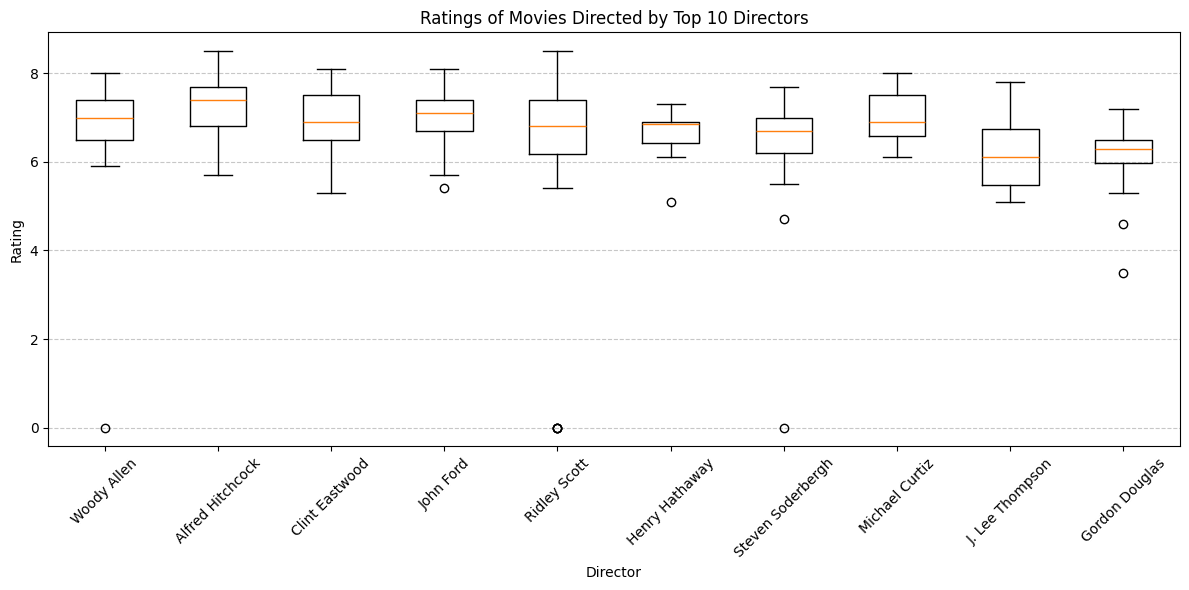

In [6]:
# Ratings of Movies Directed by Top 10 Directors

filtered_df = df_top10_directors.select("Director", "Rating").toPandas()
top_10_directors = top_directors.select("Director").rdd.flatMap(lambda x: x).collect()

fig1 = plt.figure(figsize=(12, 6))
plt.boxplot([filtered_df[filtered_df['Director'] == director]['Rating'] for director in top_10_directors], labels=top_10_directors)
plt.title('Ratings of Movies Directed by Top 10 Directors')
plt.xlabel('Director')
plt.ylabel('Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.close(fig1)

# Writer

In [13]:
# get top-10 directors

df = spark.read.csv("data/movies_clean.csv", header=True, inferSchema=True)

writer_counts = df.groupBy("Writer").count()
writer_counts = writer_counts.orderBy(desc("count"))
writer_counts = writer_counts.filter(col('Writer') != 'See writer')

top_writers = writer_counts.limit(10)

top_writers.show()

+--------------+-----+
|        Writer|count|
+--------------+-----+
|   Woody Allen|   41|
|  Stephen King|   29|
|    Luc Besson|   24|
|   Robin Bhatt|   22|
|   John Hughes|   19|
|  Javed Akhtar|   18|
|   David Mamet|   17|
|   Larry Cohen|   17|
|Puri Jagannadh|   16|
| Philip Yordan|   16|
+--------------+-----+



In [14]:
# calculate the avg max and min rating
df_top10_writers = df.join(top_writers, "Writer", "inner")
df_top10_writers = df_top10_writers.withColumn("Rating", col("Rating").cast("float"))

writer_stats = df_top10_writers.groupBy("Writer").agg(
    avg("Rating").alias("avg_rating"),
    max("Rating").alias("max_rating"),
    min("Rating").alias("min_rating")
)

writer_stats = writer_stats.orderBy(desc("avg_rating"))

top_writer_stats = writer_stats.limit(10).toPandas()
top_writer_stats

,Writer,avg_rating,max_rating,min_rating
0,Woody Allen,6.868293,8.0,0.0
1,Javed Akhtar,6.811111,8.1,4.0
2,David Mamet,6.747059,7.9,5.7
3,John Hughes,6.426316,7.8,4.5
4,Stephen King,6.410345,9.3,4.3
5,Philip Yordan,6.212500,7.6,2.1
6,Larry Cohen,5.652941,7.1,4.0
7,Luc Besson,5.533333,7.8,0.0
8,Robin Bhatt,5.145455,7.2,3.1
9,Puri Jagannadh,5.018750,7.4,0.0


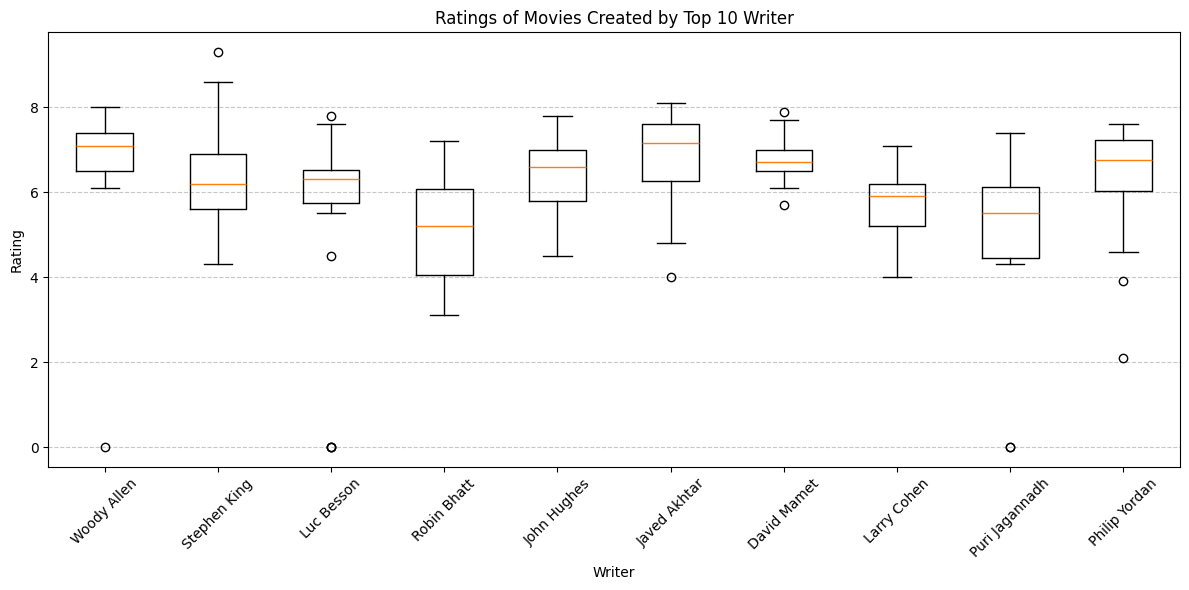

In [15]:
# Ratings of Movies Directed by Top 10 Directors

filtered_df = df_top10_writers.select("Writer", "Rating").toPandas()
top_10_writers = top_writers.select("Writer").rdd.flatMap(lambda x: x).collect()

fig2 = plt.figure(figsize=(12, 6))
plt.boxplot([filtered_df[filtered_df['Writer'] == writer]['Rating'] for writer in top_10_writers], labels=top_10_writers)
plt.title('Ratings of Movies Created by Top 10 Writer')
plt.xlabel('Writer')
plt.ylabel('Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.close(fig2)

# Top Casts

In [26]:
df = spark.read.csv("data/movies_clean.csv", header=True, inferSchema=True)

df = df.withColumn("Top 5 Casts", regexp_replace(df["Top 5 Casts"], "[\[\]']", ""))
df = df.withColumn("Top 5 Casts", translate(df["Top 5 Casts"], ", ", ","))
df = df.filter(col('Top 5 Casts') != '')

df.toPandas().head(3)

,movie title,Rating,User Rating,Generes,Overview,Plot Kyeword,Director,Top 5 Casts,Writer,year
0,Top Gun: Maverick,8.6,187000.0,"['Action', 'Drama']",After more than thirty years of service as one...,"['fighter jet', 'sequel', 'u.s. navy', 'fighte...",Joseph Kosinski,"JackEppsJr.,PeterCraig,TomCruise,JenniferConne...",Jim Cash,2022
1,Jurassic World Dominion,6.0,56000.0,"['Action', 'Adventure', 'Sci-Fi']",Four years after the destruction of Isla Nubla...,"['dinosaur', 'jurassic park', 'tyrannosaurus r...",Colin Trevorrow,"ColinTrevorrow,DerekConnolly,ChrisPratt,BryceD...",Emily Carmichael,2022
2,Top Gun,6.9,380000.0,"['Action', 'Drama']",As students at the United States Navy's elite ...,"['pilot', 'male camaraderie', 'u.s. navy', 'gr...",Tony Scott,"JackEppsJr.,EhudYonay,TomCruise,TimRobbins,Kel...",Jim Cash,1986


In [27]:
# explode Generes to a new column Genre
df = df.select(df['movie title'], explode(split(df['Top 5 Casts'],",")).alias('Casts'))

df = df.groupBy(df['Casts']).count().orderBy('count', ascending=False)
df = df.filter(col('Casts') != 'Seepreliminarycast')
df = df.filter(col('Casts') != 'Seeproducer')
df = df.filter(col('Casts') != 'UnitedStates')
df = df.filter(col('Casts') != 'English')

top_casts = df.limit(10).toPandas()
top_casts

,Casts,count
0,WoodyAllen,104
1,NicolasCage,85
2,BruceWillis,73
3,RobertDeNiro,73
4,SylvesterStallone,71
5,AmitabhBachchan,70
6,JohnWayne,68
7,AkshayKumar,64
8,SamuelL.Jackson,62
9,MichaelCaine,60


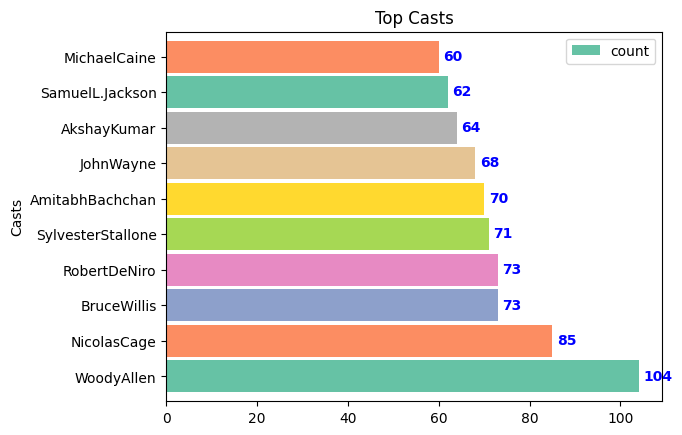

In [30]:
ax = top_casts.plot.barh(x='Casts', y='count',width=0.9, color=sns.color_palette('Set2',10))

for i, v in enumerate(top_casts['count']):
    ax.text(v + 1, i - 0.1, str(v), color='blue', fontweight='bold')

plt.title('Top Casts')
plt.show()